In [ ]:
import os
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
tf.random.set_seed(1234)
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available and recognized.")
    print("Current GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU available; using CPU.")

GPU is available and recognized.
Current GPU: Tesla T4


In [ ]:
import glob

folder_path = "/content/drive/MyDrive/data_real/falling"  # Replace with the actual path to your folder

# Use glob to get a list of all files in the folder
files = glob.glob(folder_path + "/*")

# Now, the 'files' variable contains a list of file paths in the specified folder
print(files)


['/content/drive/MyDrive/data_real/falling/falling84.csv', '/content/drive/MyDrive/data_real/falling/falling99.csv', '/content/drive/MyDrive/data_real/falling/falling89.csv', '/content/drive/MyDrive/data_real/falling/falling103.csv', '/content/drive/MyDrive/data_real/falling/falling139.csv', '/content/drive/MyDrive/data_real/falling/falling132.csv', '/content/drive/MyDrive/data_real/falling/falling33.csv', '/content/drive/MyDrive/data_real/falling/falling92.csv', '/content/drive/MyDrive/data_real/falling/falling70.csv', '/content/drive/MyDrive/data_real/falling/falling76.csv', '/content/drive/MyDrive/data_real/falling/falling126.csv', '/content/drive/MyDrive/data_real/falling/falling41.csv', '/content/drive/MyDrive/data_real/falling/falling49.csv', '/content/drive/MyDrive/data_real/falling/falling3.csv', '/content/drive/MyDrive/data_real/falling/falling86.csv', '/content/drive/MyDrive/data_real/falling/falling77.csv', '/content/drive/MyDrive/data_real/falling/falling138.csv', '/content

In [ ]:
def parse_dataset(num_points=400):
    train_points = []
    train_labels = []
    class_map = {}
    folder_path = "/content/drive/MyDrive/data_real"
    folders = glob.glob(folder_path + "/*")

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = os.path.basename(folder)
        # gather all files
        train_files = glob.glob(os.path.join(folder_path, folder) + "/*")

        for f in train_files:
            # Read the CSV file
            df = pd.read_csv(f)
            # Check if the number of points in the file is at least min_points
            if len(df) >= num_points:
                # Use the random indices to select min_points random rows from the original array
                train_points.append(df.set_index('Unnamed: 0').sample(num_points).values)
                train_labels.append(i)

    return (
        np.array(train_points),
        np.array(train_labels),
        class_map,
    )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
NUM_POINTS = 400
NUM_CLASSES = 4
BATCH_SIZE = 1
train_points,train_labels,class_map = parse_dataset(NUM_POINTS)
train_points,test_points,train_labels,test_labels=train_test_split(train_points,train_labels,test_size=0.2,random_state=42)
data_train, data_val, labels_train, labels_val = train_test_split(train_points, train_labels, test_size=0.3, random_state=42)

processing class: standing
processing class: falling
processing class: sitting
processing class: lying_down


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/data')


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
import torch

from time import time
import numpy as np

def timeit(tag, t):
    print("{}: {}s".format(tag, time() - t))
    return time()

def pc_normalize(pc):
    l = pc.shape[0]
    centroid = np.mean(pc, axis=0)
    pc = pc - centroid
    m = np.max(np.sqrt(np.sum(pc**2, axis=1)))
    pc = pc / m
    return pc

def square_distance(src, dst):
    """
    Calculate Euclid distance between each two points.

    src^T * dst = xn * xm + yn * ym + zn * zm；
    sum(src^2, dim=-1) = xn*xn + yn*yn + zn*zn;
    sum(dst^2, dim=-1) = xm*xm + ym*ym + zm*zm;
    dist = (xn - xm)^2 + (yn - ym)^2 + (zn - zm)^2
         = sum(src**2,dim=-1)+sum(dst**2,dim=-1)-2*src^T*dst

    Input:
        src: source points, [B, N, C]
        dst: target points, [B, M, C]
    Output:
        dist: per-point square distance, [B, N, M]
    """
    B, N, _ = src.shape
    _, M, _ = dst.shape
    dist = -2 * torch.matmul(src, dst.permute(0, 2, 1))
    dist += torch.sum(src ** 2, -1).view(B, N, 1)
    dist += torch.sum(dst ** 2, -1).view(B, 1, M)
    return dist


def index_points(points, idx):
    """

    Input:
        points: input points data, [B, N, C]
        idx: sample index data, [B, S]
    Return:
        new_points:, indexed points data, [B, S, C]
    """
    device = points.device
    B = points.shape[0]
    view_shape = list(idx.shape)
    view_shape[1:] = [1] * (len(view_shape) - 1)
    repeat_shape = list(idx.shape)
    repeat_shape[0] = 1
    batch_indices = torch.arange(B, dtype=torch.long).to(device).view(view_shape).repeat(repeat_shape)
    new_points = points[batch_indices, idx, :]
    return new_points


def farthest_point_sample(xyz, npoint):
    """
    Input:
        xyz: pointcloud data, [B, N, 3]
        npoint: number of samples
    Return:
        centroids: sampled pointcloud index, [B, npoint]
    """
    device = xyz.device
    B, N, C = xyz.shape
    centroids = torch.zeros(B, npoint, dtype=torch.long).to(device)
    distance = torch.ones(B, N).to(device) * 1e10
    farthest = torch.randint(0, N, (B,), dtype=torch.long).to(device)
    batch_indices = torch.arange(B, dtype=torch.long).to(device)
    for i in range(npoint):
        centroids[:, i] = farthest
        centroid = xyz[batch_indices, farthest, :].view(B, 1, 3)
        dist = torch.sum((xyz - centroid) ** 2, -1)
        mask = dist < distance
        distance[mask] = dist[mask]
        farthest = torch.max(distance, -1)[1]
    return centroids


def query_ball_point(radius, nsample, xyz, new_xyz):
    """
    Input:
        radius: local region radius
        nsample: max sample number in local region
        xyz: all points, [B, N, 3]
        new_xyz: query points, [B, S, 3]
    Return:
        group_idx: grouped points index, [B, S, nsample]
    """
    device = xyz.device
    B, N, C = xyz.shape
    _, S, _ = new_xyz.shape
    group_idx = torch.arange(N, dtype=torch.long).to(device).view(1, 1, N).repeat([B, S, 1])
    sqrdists = square_distance(new_xyz, xyz)
    group_idx[sqrdists > radius ** 2] = N
    group_idx = group_idx.sort(dim=-1)[0][:, :, :nsample]
    group_first = group_idx[:, :, 0].view(B, S, 1).repeat([1, 1, nsample])

    mask = group_idx == N
    group_idx[mask] = group_first[mask]
    return group_idx


def sample_and_group(npoint, radius, nsample, xyz, points, returnfps=False):
    """
    Input:
        npoint:
        radius:
        nsample:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, npoint, nsample, 3]
        new_points: sampled points data, [B, npoint, nsample, 3+D]
    """
    B, N, C = xyz.shape
    S = npoint
    fps_idx = farthest_point_sample(xyz, npoint) # [B, npoint, C]
    new_xyz = index_points(xyz, fps_idx)
    idx = query_ball_point(radius, nsample, xyz, new_xyz)
    grouped_xyz = index_points(xyz, idx) # [B, npoint, nsample, C]
    grouped_xyz_norm = grouped_xyz - new_xyz.view(B, S, 1, C)

    if points is not None:
        grouped_points = index_points(points, idx)
        new_points = torch.cat([grouped_xyz_norm, grouped_points], dim=-1) # [B, npoint, nsample, C+D]
    else:
        new_points = grouped_xyz_norm
    if returnfps:
        return new_xyz, new_points, grouped_xyz, fps_idx
    else:
        return new_xyz, new_points


def sample_and_group_all(xyz, points):
    """
    Input:
        xyz: input points position data, [B, N, 3]
        points: input points data, [B, N, D]
    Return:
        new_xyz: sampled points position data, [B, 1, 3]
        new_points: sampled points data, [B, 1, N, 3+D]
    """
    device = xyz.device
    B, N, C = xyz.shape
    new_xyz = torch.zeros(B, 1, C).to(device)
    grouped_xyz = xyz.view(B, 1, N, C)
    if points is not None:
        new_points = torch.cat([grouped_xyz, points.view(B, 1, N, -1)], dim=-1)
    else:
        new_points = grouped_xyz
    return new_xyz, new_points


class PointNetSetAbstraction(nn.Module):
    def __init__(self, npoint, radius, nsample, in_channel, mlp, group_all):
        super(PointNetSetAbstraction, self).__init__()
        self.npoint = npoint
        self.radius = radius
        self.nsample = nsample
        self.mlp_convs = nn.ModuleList()
        self.mlp_bns = nn.ModuleList()
        last_channel = in_channel
        for out_channel in mlp:
            self.mlp_convs.append(nn.Conv2d(last_channel, out_channel, 1))
            self.mlp_bns.append(nn.BatchNorm2d(out_channel))
            last_channel = out_channel
        self.group_all = group_all

    def forward(self, xyz, points):
        """
        Input:
            xyz: input points position data, [B, C, N]
            points: input points data, [B, D, N]
        Return:
            new_xyz: sampled points position data, [B, C, S]
            new_points_concat: sample points feature data, [B, D', S]
        """
        xyz = xyz.permute(0, 2, 1)
        if points is not None:
            points = points.permute(0, 2, 1)

        if self.group_all:
            new_xyz, new_points = sample_and_group_all(xyz, points)
        else:
            new_xyz, new_points = sample_and_group(self.npoint, self.radius, self.nsample, xyz, points)
        # new_xyz: sampled points position data, [B, npoint, C]
        # new_points: sampled points data, [B, npoint, nsample, C+D]
        new_points = new_points.permute(0, 3, 2, 1) # [B, C+D, nsample,npoint]
        for i, conv in enumerate(self.mlp_convs):
            bn = self.mlp_bns[i]
            new_points =  F.relu(bn(conv(new_points)))

        new_points = torch.max(new_points, 2)[0]
        new_xyz = new_xyz.permute(0, 2, 1)
        return new_xyz, new_points


In [ ]:
class get_model(nn.Module):
    def __init__(self,num_class,normal_channel=False):
        super(get_model, self).__init__()
        in_channel = 6 if normal_channel else 3
        self.normal_channel = normal_channel
        self.sa1 = PointNetSetAbstraction(npoint=512, radius=0.2, nsample=32, in_channel=in_channel, mlp=[64, 64, 128], group_all=False)
        self.sa2 = PointNetSetAbstraction(npoint=128, radius=0.4, nsample=64, in_channel=128 + 3, mlp=[128, 128, 256], group_all=False)
        self.sa3 = PointNetSetAbstraction(npoint=None, radius=None, nsample=None, in_channel=256 + 3, mlp=[256, 512, 1024], group_all=True)
        self.fc1 = nn.Linear(1024, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.drop1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.drop2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(256, num_class)

    def forward(self, xyz):
        B, _, _ = xyz.shape
        if self.normal_channel:
            norm = xyz[:, 3:, :]
            xyz = xyz[:, :3, :]
        else:
            norm = None
        l1_xyz, l1_points = self.sa1(xyz, norm)
        l2_xyz, l2_points = self.sa2(l1_xyz, l1_points)
        l3_xyz, l3_points = self.sa3(l2_xyz, l2_points)
        x = l3_points.view(B, 1024)
        x = self.drop1(F.relu(self.bn1(self.fc1(x))))
        x = self.drop2(F.relu(self.bn2(self.fc2(x))))
        x = self.fc3(x)
        x = F.log_softmax(x, -1)


        return x, l3_points



class get_loss(nn.Module):
    def __init__(self):
        super(get_loss, self).__init__()

    def forward(self, pred, target):
        total_loss = F.nll_loss(pred, target)

        return total_loss

In [ ]:

from torch.utils.data import DataLoader, TensorDataset


In [ ]:
train_labels.shape

(465,)

In [ ]:

import numpy as np

# Assuming your data is in a variable called 'data'
# Reshape data and labels
#train_points = np.transpose(data_train, (0, 2, 1))
data_val = np.transpose(data_val, (0, 2, 1))
data_val = torch.Tensor(data_val)
labels_val = torch.LongTensor(labels_val)


Data Augmentation:

In [ ]:
import numpy as np

def random_rotation(point_cloud):
    theta = np.random.uniform(0, 2 * np.pi)  # Random rotation angle
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
    return np.dot(point_cloud, rotation_matrix)

def random_translation(point_cloud, max_translation=0.1):
    translation = np.random.uniform(-max_translation, max_translation, size=(1, 3))
    return np.array(point_cloud) + np.array(translation)

def random_scaling(point_cloud, min_scale=0.8, max_scale=1.2):
    scale = np.random.uniform(min_scale, max_scale)
    return point_cloud * scale

def random_jitter(point_cloud, jitter_std=0.01):
    jitter = np.random.normal(0, jitter_std, size=point_cloud.shape)
    return np.array(point_cloud) + np.array(jitter)

def random_sampling(point_cloud, num_points=1024):
    if point_cloud.shape[0] > num_points:
        idx = np.random.choice(point_cloud.shape[0], num_points, replace=False)
        return point_cloud[idx]
    else:
        return point_cloud

def augment_data(point_cloud, num_augmentations=10):
    augmented_point_clouds = [point_cloud]

    for _ in range(num_augmentations):
        augmented = random_scaling(random_translation(random_rotation(random_jitter(random_sampling(point_cloud)))))
        augmented_point_clouds.append(augmented)

    return augmented_point_clouds

def augment_and_reshape_data(data, labels, num_augmentations=10):
    augmented_data = []
    augmented_labels = []

    for i in range(len(data)):
        point_cloud = data[i]
        augmented_point_clouds = augment_data(point_cloud, num_augmentations)

        augmented_data.extend(augmented_point_clouds)
        augmented_labels.extend([labels[i]] * (num_augmentations + 1))

    augmented_data = np.array(augmented_data)
    augmented_data = np.transpose(augmented_data, (0, 2, 1))

    return augmented_data, augmented_labels


In [ ]:
train_points,labels_train = augment_and_reshape_data(data_train, labels_train)
# Convert NumPy arrays to PyTorch tensors
data = torch.Tensor(train_points)
labels = torch.LongTensor(labels_train)
data=data.cuda()
labels=labels.cuda()
data = data.to(device)
labels = labels.to(device)
model = get_model(num_class=4)
model.to(device)
# Create a TensorDataset to hold your data and labels
dataset = TensorDataset(data, labels)

# Define batch size
batch_size = 32

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_data=torch.Tensor(data_val)
val_labels=torch.LongTensor(labels_val)
val_data = data_val.to(device)
val_labels = labels_val.to(device)
val_dataset = TensorDataset(val_data,val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
train_points.shape

(3575, 3, 400)

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score, roc_curve,confusion_matrix

In [ ]:
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            output, _ = model(batch_data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    all_probs = output.cpu().numpy()
    auc = roc_auc_score(all_labels, all_probs[:, 1])
    return accuracy,precision, recall, f1, auc


In [ ]:
# # Initialize your model and loss function

loss_fn = get_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
num_epochs = 20  # Increase the number of epochs
best_accuracy = 0.0
train_loss_history = []
val_loss_history = []
accuracy_history = []
for epoch in range(num_epochs):
    # Training loop
    total_loss = 0.0
    model.train()
    for batch_data, batch_labels in dataloader:
        optimizer.zero_grad()
        output, _ = model(batch_data)
        loss = loss_fn(output, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(dataloader)}")

    # Validation loop
    total_val_loss = 0.0
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_data, batch_labels in val_dataloader:
            output, _ = model(batch_data)
            val_loss = loss_fn(output, batch_labels)
            total_val_loss += val_loss.item()

            preds = output.argmax(dim=1).cpu().numpy()
            labels = batch_labels.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch + 1}, Validation Loss: {total_val_loss / len(val_dataloader)}, Accuracy: {accuracy}")

    # Update the learning rate using the scheduler
    scheduler.step()
    train_loss_history.append(total_loss / len(dataloader))
    val_loss_history.append(total_val_loss / len(val_dataloader))
    accuracy_history.append(accuracy)

    # Save the model with the best validation accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_model.pth')

print("Training complete")


Epoch 1, Training Loss: 0.6714634118335587
Epoch 1, Validation Loss: 0.8992243528366088, Accuracy: 0.6571428571428571
Epoch 2, Training Loss: 0.3785089669483049
Epoch 2, Validation Loss: 0.5775479555130005, Accuracy: 0.7642857142857142
Epoch 3, Training Loss: 0.2700046256982854
Epoch 3, Validation Loss: 0.7082647442817688, Accuracy: 0.7642857142857142
Epoch 4, Training Loss: 0.21749995928257704
Epoch 4, Validation Loss: 0.4157355934381485, Accuracy: 0.85
Epoch 5, Training Loss: 0.19220389708477473
Epoch 5, Validation Loss: 0.5260489463806153, Accuracy: 0.8642857142857143
Epoch 6, Training Loss: 0.13009993250515045
Epoch 6, Validation Loss: 0.5076460093259811, Accuracy: 0.85
Epoch 7, Training Loss: 0.06761248685818698
Epoch 7, Validation Loss: 0.6047995418310166, Accuracy: 0.8571428571428571
Epoch 8, Training Loss: 0.05407088155958003
Epoch 8, Validation Loss: 0.688527649641037, Accuracy: 0.8214285714285714
Epoch 9, Training Loss: 0.052758707569280104
Epoch 9, Validation Loss: 0.5109076

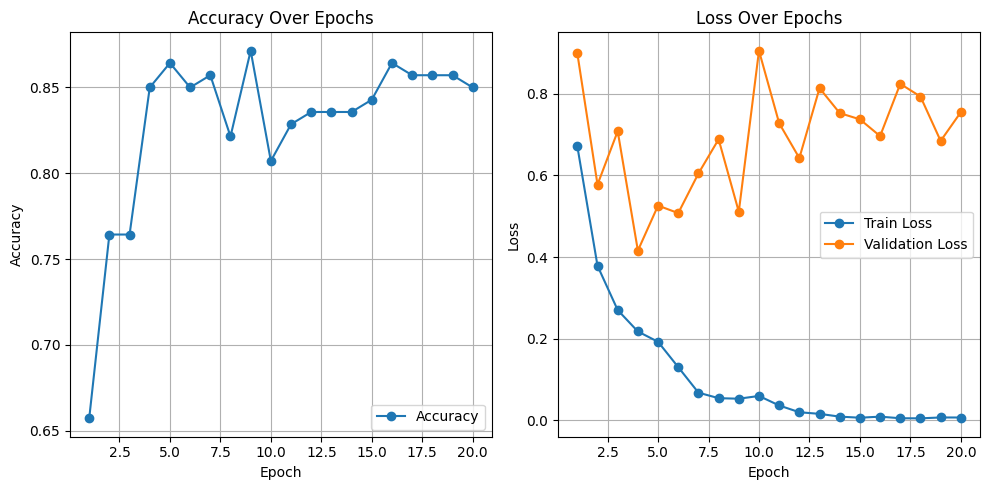

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), accuracy_history, label='Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()








In [ ]:
model = get_model(num_class=4)
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

get_model(
  (sa1): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa2): PointNetSetAbstraction(
    (mlp_convs): ModuleList(
      (0): Conv2d(131, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (mlp_bns): ModuleList(
      (0-1): 2 x BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (sa3): PointNetSetAbstract

TEST:

In [ ]:
model.eval()
test_points = test_points
test_labels =test_labels


In [ ]:
test_points=np.array(test_points)
test_labels=np.array(test_labels)

In [ ]:
test_points = np.transpose(test_points, (0, 2, 1))

In [ ]:
data_test = torch.Tensor(test_points)
labels_test = torch.LongTensor(test_labels)
data_test = data_test.to(device)
labels_test = labels_test.to(device)
data_test=data_test.cuda()
labels_test=labels_test.cuda()
# Create a TensorDataset to hold your data and labels
dataset_test = TensorDataset(data_test, labels_test)

# Define batch size
batch_size = 32

# Create a DataLoader
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [ ]:
tot_test_loss = 0.0
preds = []
labs = []

with torch.no_grad():
    for batch_data, batch_labels in dataloader_test:
        output, _ = model(batch_data)
        test_loss = loss_fn(output, batch_labels)
        tot_test_loss += test_loss.item()

        pred = output.argmax(dim=1).cpu().numpy()
        label = batch_labels.cpu().numpy()
        preds.extend(pred)
        labs.extend(label)

accuracys = accuracy_score(labs, preds)
precision = precision_score(labs, preds,average='weighted')
recall = recall_score(labs, preds,average='weighted')
f1 = f1_score(labs, preds,average='weighted')
cm = confusion_matrix(all_labels, all_preds)
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print(f" Testing Loss: {tot_test_loss / len(dataloader_test)}, Accuracy: {accuracys}")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("confusion matrix",cm)

 Testing Loss: 0.7407627776265144, Accuracy: 0.8461538461538461
Precision: 0.8411680911680912
Recall: 0.8461538461538461
F1 Score: 0.8423251252073213
Sensitivity: 0.9090909090909091
Specificity: 0.95
confusion matrix [[19  1  1  0]
 [ 2 20  0  2]
 [ 0  3 27  1]
 [ 1  9  1 53]]


In [ ]:
np.save('train.npy',train_points)

In [ ]:
np.save('train_labels.npy',train_labels)

In [ ]:
np.save('test.npy',test_points)

In [ ]:
np.save('test_labels.npy',test_labels)